# PSF simulation for Spiral 3DREAM

## Python standard libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from bart import bart

## From DreamMap.py (https://gitlab.com/pehses/3dream-example)

In [8]:
from numpy.fft import fftshift, ifftshift, ifftn, fftn
import collections

def kspace_to_image(sig, dim=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions

    :param img: image space data
    :param dim: vector of dimensions to transform
    :returns: data in k-space (along transformed dimensions)
    """
    if dim is None:
        dim = range(sig.ndim)
    elif not isinstance(dim, collections.abc.Iterable):
        dim = [dim]

    sig = ifftshift(sig, axes=dim)
    sig = ifftn(sig, axes=dim)
    sig = ifftshift(sig, axes=dim)

    # sig = fftshift(fftn(fftshift(sig, axes=dim), axes=dim), axes=dim)
    # sig = ifftshift(ifftn(ifftshift(sig, axes=dim), axes=dim), axes=dim)

    return sig


def image_to_kspace(sig, dim=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions

    :param img: image space data
    :param dim: vector of dimensions to transform
    :returns: data in k-space (along transformed dimensions)
    """
    if dim is None:
        dim = range(sig.ndim)
    elif not isinstance(dim, collections.abc.Iterable):
        dim = [dim]

    sig = fftshift(sig, axes=dim)
    sig = fftn(sig, axes=dim)
    sig = fftshift(sig, axes=dim)

    # sig = ifftshift(ifftn(ifftshift(sig, axes=dim), axes=dim), axes=dim)
    # sig = fftshift(fftn(fftshift(sig, axes=dim), axes=dim), axes=dim)

    return sig

def cfftn(data, axes):
    """ Centered fast fourier transform, n-dimensional.

    :param data: Complex input data.
    :param axes: Axes along which to shift and transform.
    :return: Fourier transformed data.
    """
    return fftshift(fftn(ifftshift(data, axes=axes), axes=axes, norm='ortho'), axes=axes)

## PSF for sensitivity maps calculation

In [9]:
# Useful data from a non accelerated scan:
raw = np.load('/home/niesens/Documents/fire_setup/debug/raw_ste.npy')
trj = np.load('/home/niesens/Documents/fire_setup/debug/trj_ste.npy')

# Create PSF_ksp:
PSF_ksp = np.ones(np.asarray(raw.shape[:]),dtype=complex)

# Reconstruction of unpadded, but filtered PSF:
sensmaps = bart(1, 'nufft -i -m 20 -l 0.005 -c -t -d %d:%d:%d'%(40, 40, 40), trj, PSF_ksp)
sensmaps = cfftn(sensmaps, [0, 1, 2])
sensmaps = bart(1,'ecalib -m 1 -I -r 20 -k 4', sensmaps)

## PSF calculation: not filtered

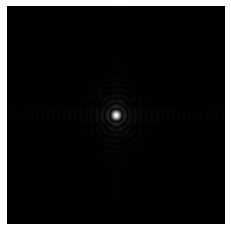

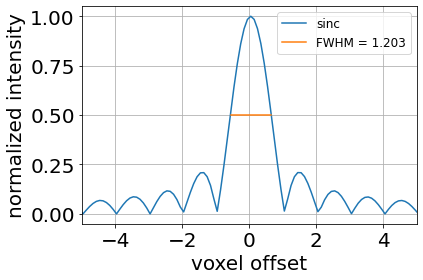

In [11]:
global_filt = False

# Useful data:
raw = np.load('/home/niesens/Documents/fire_setup/debug/raw_ste.npy')
trj = np.load('/home/niesens/Documents/fire_setup/debug/trj_ste.npy')

# Read filt_arr:
filt_arr = np.load('/home/niesens/Documents/fire_setup/debug/filt_arr.npy')

# Create PSF_ksp:
PSF_ksp = np.ones(np.asarray(raw.shape[:]),dtype=complex)

# Global filter on PSF_ksp:
if global_filt:
    for rep in range(filt_arr.size):
        PSF_ksp[:,:,rep,:] *= filt_arr[rep]

# Reconstruction of unpadded, but filtered PSF:
PSF_filt = bart(1, 'pics -S -e -l1 -r 0.001 -i 50 -t' , trj, PSF_ksp, sensmaps)

# FFT to k-space:
PSF_filt_ksp = image_to_kspace(PSF_filt,dim=(0,1,2))

# Zero-Padding in k-space:
fac = 10
PSF_incrmatr = np.zeros([fac*PSF_filt_ksp.shape[0],fac*PSF_filt_ksp.shape[1],fac*PSF_filt_ksp.shape[2]],dtype=complex)
indx = int(fac*PSF_filt_ksp.shape[0] / 2) - int(PSF_filt_ksp.shape[0] / 2)
PSF_incrmatr[indx:indx+PSF_filt_ksp.shape[0],indx:indx+PSF_filt_ksp.shape[1],indx:indx+PSF_filt_ksp.shape[2]] = PSF_filt_ksp.copy()

# PSF in image-space:
PSF_img_unf = kspace_to_image(PSF_incrmatr,dim=[0,1,2])
x_unf = np.linspace(-20, 20, PSF_img_unf.shape[0])

# Plotting:
plt.figure(1)
plt.imshow(abs(PSF_img_unf[:,:,int(PSF_img_unf.shape[0]/2)]), cmap='gray')
plt.axis("off")

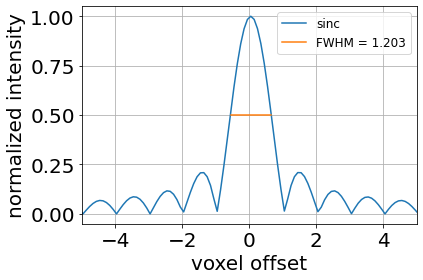

In [14]:
# FWHM calculation:
sinc_unf = abs(PSF_img_unf[int(PSF_img_unf.shape[0]/2),int(PSF_img_unf.shape[0]//2),:]) / (abs(PSF_img_unf[int(PSF_img_unf.shape[0]/2),int(PSF_img_unf.shape[0]//2),:]).max())
miniposi = min(min(np.where(sinc_unf>=0.5)))
maxiposi = max(max(np.where(sinc_unf>=0.5)))
fwhm_unf=x_unf[maxiposi]-x_unf[miniposi]

plt.figure(2)
plt.plot(x_unf, sinc_unf, label="sinc")
plt.plot([x_unf[miniposi],x_unf[maxiposi]],[0.5,0.5], label="FWHM = {}".format(round(fwhm_unf,3)))
plt.xlim([-5,5])
plt.grid('on')
plt.xlabel('voxel offset', fontsize=20)
plt.ylabel('normalized intensity', fontsize=20)
plt.legend(fontsize=12)
plt.tick_params(labelsize=20)
plt.show()

## PSF calculation: non accelerated

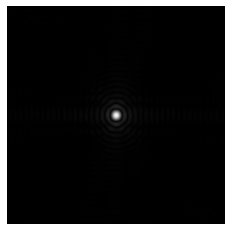

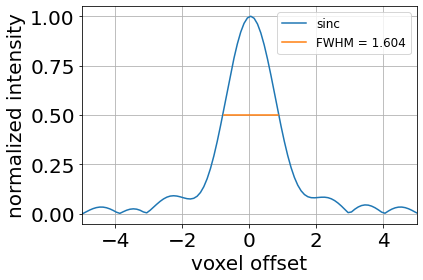

In [10]:
global_filt = True

# Useful data:
raw = np.load('/home/niesens/Documents/fire_setup/debug/raw_ste.npy')
trj = np.load('/home/niesens/Documents/fire_setup/debug/trj_ste.npy')

# Read filt_arr:
filt_arr = np.load('/home/niesens/Documents/fire_setup/debug/filt_arr.npy')

# Create PSF_ksp:
PSF_ksp = np.ones(np.asarray(raw.shape[:]),dtype=complex)

# Global filter on PSF_ksp:
if global_filt:
    for rep in range(filt_arr.size):
        PSF_ksp[:,:,rep,:] *= filt_arr[rep]

# Reconstruction of unpadded, but filtered PSF:
PSF_filt = bart(1, 'pics -S -e -l1 -r 0.001 -i 50 -t' , trj, PSF_ksp, sensmaps)

# FFT to k-space:
PSF_filt_ksp = image_to_kspace(PSF_filt,dim=(0,1,2))

# Zero-Padding in k-space:
fac = 10
PSF_incrmatr = np.zeros([fac*PSF_filt_ksp.shape[0],fac*PSF_filt_ksp.shape[1],fac*PSF_filt_ksp.shape[2]],dtype=complex)
indx = int(fac*PSF_filt_ksp.shape[0] / 2) - int(PSF_filt_ksp.shape[0] / 2)
PSF_incrmatr[indx:indx+PSF_filt_ksp.shape[0],indx:indx+PSF_filt_ksp.shape[1],indx:indx+PSF_filt_ksp.shape[2]] = PSF_filt_ksp.copy()

# PSF in image-space:
PSF_img_nonacc = kspace_to_image(PSF_incrmatr,dim=[0,1,2])
x_nonacc = np.linspace(-20, 20, PSF_img_nonacc.shape[0])

# Plotting:
plt.figure(1)
plt.imshow(abs(PSF_img_nonacc[:,:,int(PSF_img_nonacc.shape[0]/2)]), cmap='gray')
plt.axis("off")

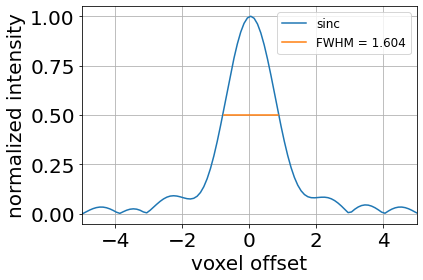

In [15]:
# FWHM calculation:
sinc_nonacc = abs(PSF_img_nonacc[int(PSF_img_nonacc.shape[0]/2),int(PSF_img_nonacc.shape[0]//2),:]) / (abs(PSF_img_nonacc[int(PSF_img_nonacc.shape[0]/2),int(PSF_img_nonacc.shape[0]//2),:]).max())
miniposi = min(min(np.where(sinc_nonacc>=0.5)))
maxiposi = max(max(np.where(sinc_nonacc>=0.5)))
fwhm_nonacc=x_nonacc[maxiposi]-x_nonacc[miniposi]

plt.figure(2)
plt.plot(x_nonacc, sinc_nonacc, label="sinc")
plt.plot([x_nonacc[miniposi],x_nonacc[maxiposi]],[0.5,0.5], label="FWHM = {}".format(round(fwhm_nonacc,3)))
plt.xlim([-5,5])
plt.grid('on')
plt.xlabel('voxel offset', fontsize=20)
plt.ylabel('normalized intensity', fontsize=20)
plt.legend(fontsize=12)
plt.tick_params(labelsize=20)
plt.show()

## PSF calculation: accelerated

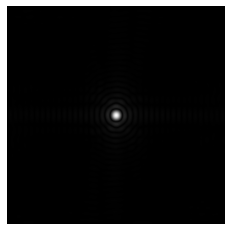

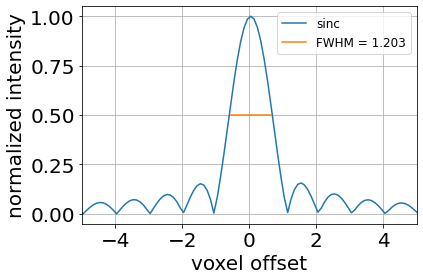

In [12]:
global_filt = True

# Useful data:
raw = np.load('/home/niesens/Documents/fire_setup/debug/raw_ste.npy')
trj = np.load('/home/niesens/Documents/fire_setup/debug/trj_ste.npy')

# Read filt_arr:
filt_arr = np.load('/home/niesens/Documents/fire_setup/debug/filt_arr.npy')

# Create PSF_ksp:
PSF_ksp = np.ones(np.asarray(raw.shape[:]),dtype=complex)

# Global filter on PSF_ksp:
if global_filt:
    for rep in range(filt_arr.size):
        PSF_ksp[:,:,rep,:] *= filt_arr[rep]

# Reconstruction of unpadded, but filtered PSF:
PSF_filt = bart(1, 'pics -S -e -l1 -r 0.001 -i 50 -t' , trj, PSF_ksp, sensmaps)

# FFT to k-space:
PSF_filt_ksp = image_to_kspace(PSF_filt,dim=(0,1,2))

# Zero-Padding in k-space:
fac = 10
PSF_incrmatr = np.zeros([fac*PSF_filt_ksp.shape[0],fac*PSF_filt_ksp.shape[1],fac*PSF_filt_ksp.shape[2]],dtype=complex)
indx = int(fac*PSF_filt_ksp.shape[0] / 2) - int(PSF_filt_ksp.shape[0] / 2)
PSF_incrmatr[indx:indx+PSF_filt_ksp.shape[0],indx:indx+PSF_filt_ksp.shape[1],indx:indx+PSF_filt_ksp.shape[2]] = PSF_filt_ksp.copy()

# PSF in image-space:
PSF_img_acc = kspace_to_image(PSF_incrmatr,dim=[0,1,2])
x_acc = np.linspace(-20, 20, PSF_img_acc.shape[0])

# Plotting:
plt.figure(1)
plt.imshow(abs(PSF_img_acc[:,:,int(PSF_img_acc.shape[0]/2)]), cmap='gray')
plt.axis("off")

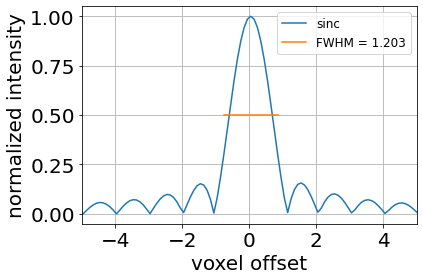

In [16]:
# FWHM calculation:
sinc_acc = abs(PSF_img_acc[int(PSF_img_acc.shape[0]/2),int(PSF_img_acc.shape[0]//2),:]) / (abs(PSF_img_acc[int(PSF_img_acc.shape[0]/2),int(PSF_img_acc.shape[0]//2),:]).max())
miniposi = min(min(np.where(sinc_acc>=0.5)))
maxiposi = max(max(np.where(sinc_acc>=0.5)))
fwhm_acc=x_acc[maxiposi]-x_acc[miniposi]

plt.figure(2)
plt.plot(x_acc, sinc_acc, label="sinc")
plt.plot([x_acc[miniposi],x_acc[maxiposi]],[0.5,0.5], label="FWHM = {}".format(round(fwhm_acc,3)))
plt.xlim([-5,5])
plt.grid('on')
plt.xlabel('voxel offset', fontsize=20)
plt.ylabel('normalized intensity', fontsize=20)
plt.legend(fontsize=12)
plt.tick_params(labelsize=20)
plt.show()

## Plotting

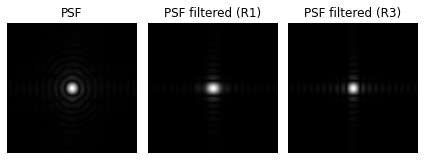

In [18]:
fig, axes = plt.subplots(1, 3)
axes[0].set_title('PSF')
axes[0].imshow(abs(PSF_img_unf[100:300,100:300,int(PSF_img_unf.shape[0]/2)]), cmap='gray')
axes[0].axis("off")
axes[1].set_title('PSF filtered (R1)')
axes[1].imshow(abs(PSF_img_nonacc[100:300,int(PSF_img_nonacc.shape[0]/2),100:300]), cmap='gray')
axes[1].axis("off")
axes[2].set_title('PSF filtered (R3)')
axes[2].imshow(abs(PSF_img_acc[100:300,int(PSF_img_acc.shape[0]/2),100:300]), cmap='gray')
axes[2].axis("off")
fig.tight_layout()

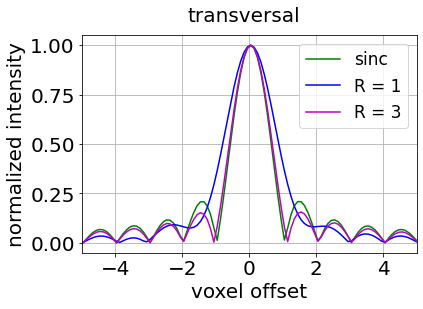

In [19]:
fig = plt.figure()
fig.suptitle('transversal', fontsize=20)
plt.plot(x_unf, sinc_unf,'g-', label="sinc")
plt.plot(x_nonacc, sinc_nonacc, 'b-', label="R = 1")
plt.plot(x_acc, sinc_acc, 'm-', label="R = 3")
plt.xlim([-5,5])
plt.grid('on')
plt.xlabel('voxel offset', fontsize=20)
plt.ylabel('normalized intensity', fontsize=20)
plt.legend(fontsize=17)
plt.tick_params(labelsize=20)

In [20]:
print("R1: FWHM = {}".format(fwhm_nonacc))
print("R3: FWHM = {}".format(fwhm_acc))

R1: FWHM = 1.6040100250626566
R3: FWHM = 1.2030075187969942
